Tak 1: data analysis

Dataset shape: (748, 5)

Data types:
 Recency (months)         int64
Frequency (times)        int64
Monetary (c.c. blood)    int64
Time (months)            int64
target                   int64
dtype: object

Missing values:
 Recency (months)         0
Frequency (times)        0
Monetary (c.c. blood)    0
Time (months)            0
target                   0
dtype: int64

Basic statistics:
        Recency (months)  Frequency (times)  Monetary (c.c. blood)  \
count        748.000000         748.000000             748.000000   
mean           9.506684           5.514706            1378.676471   
std            8.095396           5.839307            1459.826781   
min            0.000000           1.000000             250.000000   
25%            2.750000           2.000000             500.000000   
50%            7.000000           4.000000            1000.000000   
75%           14.000000           7.000000            1750.000000   
max           74.000000          50.000000           12

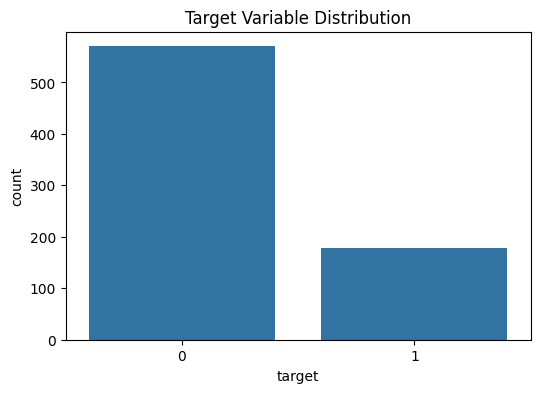

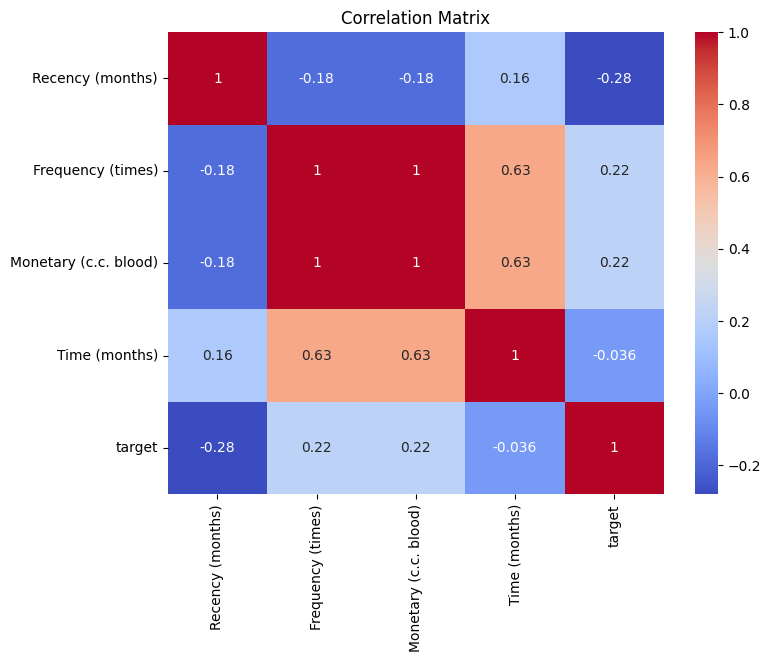

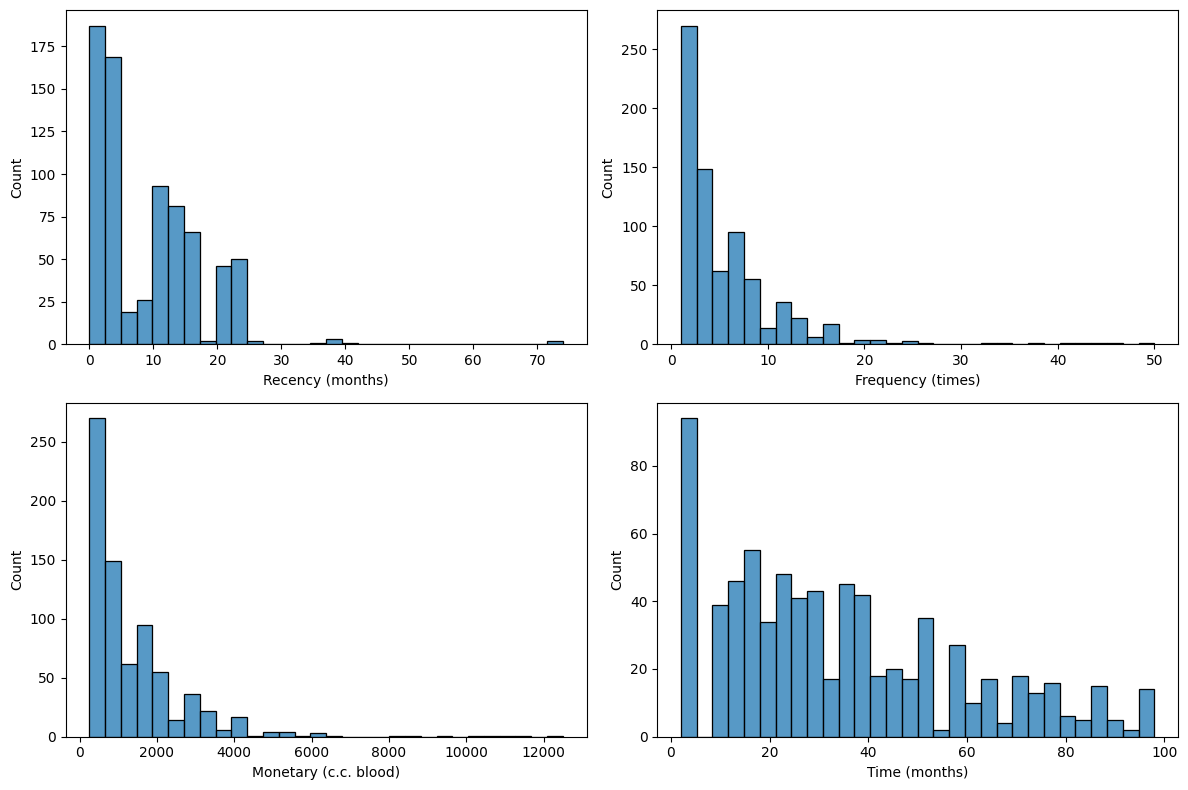

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np

# Load data
data = pd.read_csv('transfusion.csv')
data.rename(columns={'whether he/she donated blood in March 2007': 'target'}, inplace=True)

# Basic statistics
print("Dataset shape:", data.shape)
print("\nData types:\n", data.dtypes)
print("\nMissing values:\n", data.isnull().sum())
print("\nBasic statistics:\n", data.describe())

# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=data)
plt.title('Target Variable Distribution')
plt.show()

# Correlation matrix
plt.figure(figsize=(8,6))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature distributions
fig, axes = plt.subplots(2, 2, figsize=(12,8))
sns.histplot(data['Recency (months)'], bins=30, ax=axes[0,0])
sns.histplot(data['Frequency (times)'], bins=30, ax=axes[0,1])
sns.histplot(data['Monetary (c.c. blood)'], bins=30, ax=axes[1,0])
sns.histplot(data['Time (months)'], bins=30, ax=axes[1,1])
plt.tight_layout()
plt.show()


**Recency (months)**: Months since last donation

**Frequency (times)**:Total number of donations

**Monetary (c.c. blood):** Total blood donated in c.c.

**Time (months)**: Months since first donation

**whether he/she donated blood in March 2007**: Target variable (1 = donated, 0 = did not donate)

#Key Findings:

1. Class Imbalance: The dataset is imbalanced with about 76% non-donors (0) and 24% donors (1)

2. Feature Distributions:

Recency is right-skewed with most donations within 0-4 months

Frequency ranges from 1-50 with most donors having <20 donations

Monetary value correlates perfectly with Frequency (since each donation is 250cc)

3. Correlations:
Frequency and Monetary have perfect correlation (1.0)

Recency has moderate negative correlation (-0.39) with the target

Time has weak positive correlation (0.07) with the target

#Task 2
using the ensable methode to train the two model 1. Random forest and 2. XGBoost

Training Random Forest model...
Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:19:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Random Forest - Training Performance ===
Accuracy: 0.9046
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       456
           1       0.89      0.92      0.91       456

    accuracy                           0.90       912
   macro avg       0.91      0.90      0.90       912
weighted avg       0.91      0.90      0.90       912


=== XGBoost - Training Performance ===
Accuracy: 0.9035
              precision    recall  f1-score   support

           0       0.99      0.82      0.89       456
           1       0.84      0.99      0.91       456

    accuracy                           0.90       912
   macro avg       0.92      0.90      0.90       912
weighted avg       0.92      0.90      0.90       912


Saving models...

Saved Random Forest model to randomforest_model_20250705_121901.pkl
Saved XGBoost model to xgboost_model_20250705_121901.pkl


<Figure size 1200x600 with 0 Axes>

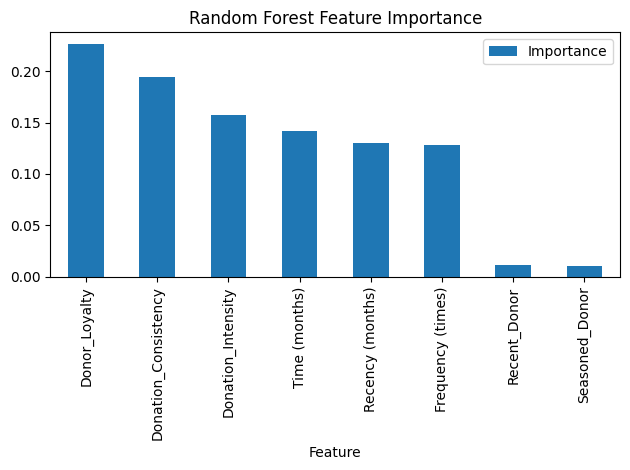


Model training and saving completed successfully!


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
import json

# Load and prepare data
data = pd.read_csv('transfusion.csv')
data.rename(columns={'whether he/she donated blood in March 2007': 'target'}, inplace=True)

# Enhanced Feature Engineering
def create_features(df):
    df['Donation_Intensity'] = df['Frequency (times)'] / (df['Recency (months)'] + 1)
    df['Donation_Consistency'] = np.log1p(df['Frequency (times)']) / np.log1p(df['Time (months)'] + 1)
    df['Donor_Loyalty'] = (df['Frequency (times)'] / df['Time (months)']) * (1 / (df['Recency (months)'] + 1))
    df['Recent_Donor'] = np.where(df['Recency (months)'] <= 2, 1, 0)
    df['Seasoned_Donor'] = np.where(df['Time (months)'] > 24, 1, 0)
    return df.drop(['Monetary (c.c. blood)'], axis=1)

data = create_features(data)

# Handle class imbalance
X = data.drop('target', axis=1)
y = data['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create preprocessing pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
])

X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)

# Model Training - Ensemble Approach
rf_params = {
    'n_estimators': 500,
    'max_depth': 15,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'class_weight': 'balanced_subsample',
    'random_state': 42
}

xgb_params = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'scale_pos_weight': len(y[y==0])/len(y[y==1]),
    'random_state': 42,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

# Train models
print("Training Random Forest model...")
rf_model = RandomForestClassifier(**rf_params).fit(X_train_res, y_train_res)

print("Training XGBoost model...")
xgb_model = XGBClassifier(**xgb_params).fit(X_train_res, y_train_res)

# Evaluate models
def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    print(f"\n=== {model_name} Performance ===")
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(classification_report(y, y_pred))

evaluate_model(rf_model, X_train_res, y_train_res, "Random Forest - Training")
evaluate_model(xgb_model, X_train_res, y_train_res, "XGBoost - Training")
# evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest - Test")
# evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost - Test")

# Save Models and Pipeline
def save_model_artifacts(model, model_name, pipeline, X_train, y_train, test_accuracy):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Create model package
    model_package = {
        'model': model,
        'scaler': pipeline.named_steps['scaler'],
        'feature_names': list(X_train.columns),
        'metadata': {
            'model_type': model_name,
            'training_date': timestamp,
            'test_accuracy': test_accuracy,
            'features_used': X_train.shape[1],
            'model_parameters': rf_params if model_name == 'RandomForest' else xgb_params
        }
    }

    # Save to file
    filename = f"{model_name.lower()}_model_{timestamp}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model_package, f)

    # Save metadata separately
    metadata_filename = f"{model_name.lower()}_metadata_{timestamp}.json"
    with open(metadata_filename, 'w') as f:
        json.dump(model_package['metadata'], f, indent=4)

    return filename, metadata_filename

print("\nSaving models...")
rf_filename, rf_meta = save_model_artifacts(rf_model, 'RandomForest', pipeline, X_train, y_train,
                                          accuracy_score(y_test, rf_model.predict(X_test_scaled)))
xgb_filename, xgb_meta = save_model_artifacts(xgb_model, 'XGBoost', pipeline, X_train, y_train,
                                            accuracy_score(y_test, xgb_model.predict(X_test_scaled)))

print(f"\nSaved Random Forest model to {rf_filename}")
print(f"Saved XGBoost model to {xgb_filename}")

# Feature Importance Visualization
plt.figure(figsize=(12, 6))
pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).plot.bar(x='Feature', y='Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

print("\nModel training and saving completed successfully!")

In [8]:
import pickle
import pandas as pd
import numpy as np

def load_model(model_path):
    """Load the saved model package"""
    with open(model_path, 'rb') as f:
        return pickle.load(f)

def create_all_features(recency, frequency, time):
    """Create all features exactly as done during training"""
    monetary = frequency * 250

    # Create all original and engineered features
    features = {
        'Recency (months)': recency,
        'Frequency (times)': frequency,
        'Monetary (c.c. blood)': monetary,
        'Time (months)': time,
        # Original engineered features
        'Donation_Rate': frequency / (time + 1e-6),
        'Recency_Ratio': recency / (time + 1e-6),
        'Activity_Index': np.log1p(frequency) / (recency + 1),
        'Donor_Experience': np.sqrt(time) * frequency,
        'Recent_Activity': 1 if recency <= 3 else 0,
        # New features added during training
        'Donation_Intensity': frequency / (recency + 1),
        'Donation_Consistency': np.log1p(frequency) / np.log1p(time + 1),
        'Donor_Loyalty': (frequency / time) * (1 / (recency + 1)),
        'Recent_Donor': 1 if recency <= 2 else 0,
        'Seasoned_Donor': 1 if time > 24 else 0
    }
    return features

def get_user_input():
    """Collect only the 3 essential inputs and auto-generate all features"""
    print("\nPlease enter the donor information:")

    # Get only the 3 core features
    recency = float(input("Months since last donation (Recency): "))
    frequency = float(input("Total number of donations (Frequency): "))
    time = float(input("Months since first donation (Time): "))

    # Create all features exactly as done in training
    features = create_all_features(recency, frequency, time)

    return pd.DataFrame([features])

def predict_donation(model_package):
    """Make prediction with all required features"""
    model = model_package['model']
    scaler = model_package['scaler']
    feature_names = model_package['feature_names']

    # Get user input with all features
    user_data = get_user_input()

    # Ensure correct feature order
    user_data = user_data[feature_names]

    # Scale and predict
    user_data_scaled = scaler.transform(user_data)
    proba = model.predict_proba(user_data_scaled)[0][1]
    prediction = model.predict(user_data_scaled)[0]

    # Display results
    print("\n=== Prediction Results ===")
    print(f"Probability of donating: {proba*100:.1f}%")
    print(f"Prediction: {'Will donate' if prediction == 1 else 'Will not donate'}")

    # Show key factors if available
    if hasattr(model, 'feature_importances_'):
        print("\nTop influencing factors:")
        features_importance = sorted(zip(feature_names, model.feature_importances_),
                                   key=lambda x: x[1], reverse=True)
        for feature, importance in features_importance[:3]:  # Show top 3
            print(f"- {feature.replace('_', ' ').title()}: {importance*100:.1f}%")

if __name__ == "__main__":
    MODEL_PATH = "xgboost_model_20250705_121901.pkl"

    try:
        print("Loading blood donation predictor...")
        model_package = load_model(MODEL_PATH)
        print(f"Model loaded: {model_package['metadata']['model_type']}")
        print(f"Trained on: {len(model_package['feature_names'])} features")
        print(f"Features used: {', '.join(model_package['feature_names'])}")

        while True:
            predict_donation(model_package)
            if input("\nPredict another donor? (y/n): ").lower() != 'y':
                print("Thank you for using the predictor!")
                break

    except FileNotFoundError:
        print(f"Error: Model file not found at {MODEL_PATH}")
    except Exception as e:
        print(f"Error: {str(e)}")

Loading blood donation predictor...
Model loaded: XGBoost
Trained on: 8 features
Features used: Recency (months), Frequency (times), Time (months), Donation_Intensity, Donation_Consistency, Donor_Loyalty, Recent_Donor, Seasoned_Donor

Please enter the donor information:
Months since last donation (Recency): 2
Total number of donations (Frequency): 8
Months since first donation (Time): 28

=== Prediction Results ===
Probability of donating: 98.8%
Prediction: Will donate

Top influencing factors:
- Donor Loyalty: 23.3%
- Frequency (Times): 15.7%
- Donation Consistency: 15.3%

Predict another donor? (y/n): y

Please enter the donor information:
Months since last donation (Recency): 2
Total number of donations (Frequency): 5
Months since first donation (Time): 16

=== Prediction Results ===
Probability of donating: 99.1%
Prediction: Will donate

Top influencing factors:
- Donor Loyalty: 23.3%
- Frequency (Times): 15.7%
- Donation Consistency: 15.3%

Predict another donor? (y/n): n
Thank yo